# Barotropic Streamfunction in MOM5/MOM6

The barotropic streamfunction ($\psi$) is obtained from the integration of the velocity field starting from a physical boundary at which we know the transport is zero. The difference between to streamlines is a measure of the transport between them. 

There are different ways to calculate it depending on your choice of boundary for the integration. This notebook calculates it integrating in the meridional space, starting from the Antarctic continent using the zonal velocity field:

$$
\psi = \int_{y_{\rm Antarctica}}^{y} U \, \mathrm{d}y ,
$$

where $U = \int u \, \mathrm{dz}$ is the depth-integrated $u$-velocity.

In [1]:
import cosima_cookbook as cc
import numpy as np

import cf_xarray as cfxr
import cf_xarray.units
import pint_xarray
from pint import application_registry as ureg

import matplotlib.path as mpath
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean

import dask.distributed as dask
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

Initialise a dask client

In [2]:
client = dask.Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39381,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:41377,Total threads: 4
Dashboard: /proxy/35683/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:35939,


Load a session to access the COSIMA database

In [3]:
session = cc.database.create_session()

The dictionary below specifies experiment, start and ending times for each model we can use (MOM5 or MOM6). 

If you want a different experiment, or a different time period, change the necessary values.

(We refer to the [tutorial](https://cosima-recipes.readthedocs.io/en/latest/Tutorials/Using_Explorer_tools.html) for more details on how to explore the available experiments and available output variables that exist in the cookbook database.)

In [4]:
model_args = {"mom5": {"expt": "01deg_jra55v13_ryf9091",
                       "variable": "tx_trans_int_z",
                       "start_time": "2035-01-01",
                       "end_time": "2050-01-01"},

              "mom6": {"expt": "panant-01-zstar-v13",
                       "variable": "umo_2d",
                       "start_time": "2035-01-01",
                       "end_time": "2050-01-01",
                       "frequency": "1 monthly"}
             }

## Functions to load data

The functions below will load the necessary data, and calculate the barotropic streamfunction

In [5]:
def load_zonal_transport(model):
    """Load the zonal volume transport from ``model`` (either 'mom5' or 'mom6')."""

    # the reference density
    ρ0 = 1035 * ureg.kilogram / ureg.meter**3

    experiment = model_args[model]["expt"]
    start_time = model_args[model]["start_time"]
    end_time = model_args[model]["end_time"]

    mass_transport = cc.querying.getvar(session = session, **model_args[model], chunks={'time': 3})
    
    # ensure we get the time-slice we wanted
    mass_transport = mass_transport.sel(time = slice(start_time, end_time))
    
    # use pint to properly deal with units and unit conversions
    mass_transport = mass_transport.pint.quantify()
    
    volume_transport = mass_transport / ρ0
    volume_transport = volume_transport.pint.to('sverdrup') # convert units to Sv
    volume_transport.attrs['units'] = volume_transport.pint.units

    return volume_transport

def calculate_streamfunction(model):
    """Compute the streamfunction ψ for ``model`` (either 'mom5' or 'mom6')."""

    volume_transport = load_zonal_transport(model)

    ψ = volume_transport.cf.cumsum('latitude')
    
    ψ = ψ.rename('psi')
    ψ.attrs['Standard name'] = 'Barotropic streamfunction'
    ψ.attrs['units'] = ψ.pint.units
    ψ.pint.quantify()
    
    return ψ

## Calculate the barotropic streamfunction and its time-mean

Now we compute the streamfunction using `calculate_streamfunction()`.

In [6]:
ψ = {}
ψ['mom5'] = calculate_streamfunction('mom5')
ψ['mom6'] = calculate_streamfunction('mom6')

Calculate the time-mean of the streamfunction.

In [7]:
ψ_mean = {}

ψ_mean['mom5'] = ψ['mom5'].cf.mean('time').load()
ψ_mean['mom6'] = ψ['mom6'].cf.mean('time').load()

## Let's plot

We define a nice plotting method...

In [8]:
def circumpolar_map():
    fig = plt.figure(figsize = (12, 8))
    ax = plt.axes(projection = ccrs.SouthPolarStereo())
    ax.set_extent([-180, 180, -80, -40], crs=ccrs.PlateCarree())

    # Map the plot boundaries to a circle
    theta = np.linspace(0, 2 * np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

    # Add land features and gridlines
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                                edgecolor='black',
                                                facecolor='papayawhip',
                                                linewidth=0.5),
                   zorder = 2)

    return fig, ax

... and finally, it's time to visualise the streamfunction!

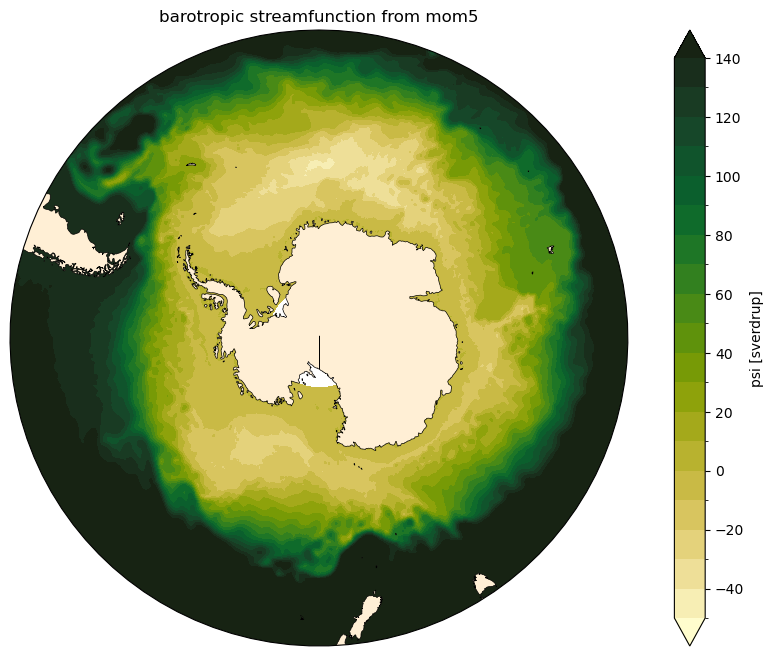

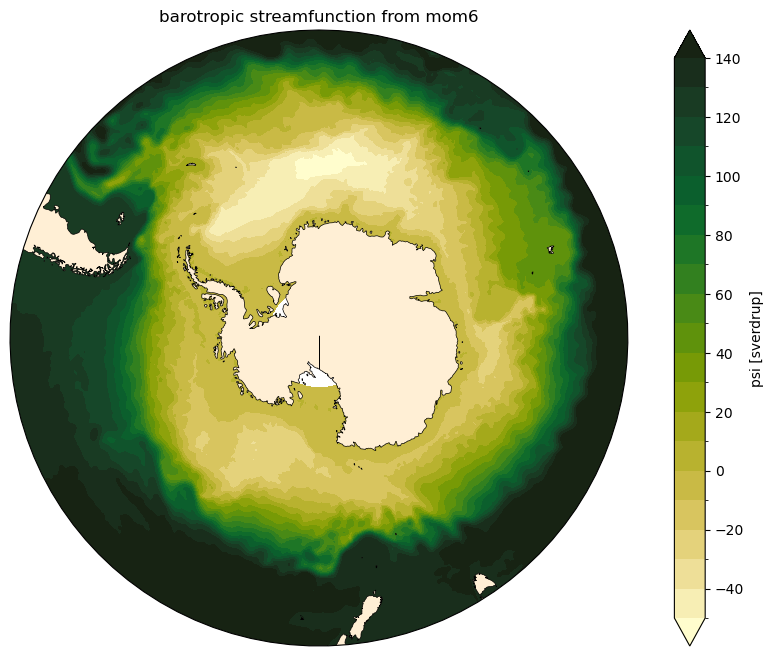

In [9]:
levels = np.arange(-50, 150, 10) # levels used in contour plots

for model in ['mom5', 'mom6']:

    fig, ax = circumpolar_map()

    ψ_mean[model].cf.plot.contourf(ax = ax,
                                   x = 'longitude',
                                   y = 'latitude', 
                                   transform = ccrs.PlateCarree(),
                                   levels = levels,
                                   extend = 'both',
                                   cmap = cmocean.cm.speed)

    plt.title('barotropic streamfunction from ' + model)